In [1]:
# this entry is necessary when using matplotlib in a jupyter notebook
# %matplotlib notebook

# for notebook version 7+, need ipympl, $ pip install ipympl, or $ conda install -c conda-forge ipympl
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

import OpenVisus as ov

# Enable I/O component of OpenVisus
ov.DbModule.attach()

from scipy.ndimage import rotate as ndimage_rotate # Import the rotate function

import pathlib

In [ ]:
# dataset = ov.LoadDataset("https://klacansky.com/open-scivis-datasets/backpack/backpack.idx")

# local_raw_path = "C:/Users/wwenj/OneDrive/Desktop/CS 5040/notebooks/Group Project/backpack_512x512x373_uint16.raw"
# dataset_url = f"raw://{local_raw_path}?dims=512,512,373&dtype=uint16"
# dataset = ov.LoadDataset(dataset_url)

# print(type(dataset))
# print(dataset.shape)
# print(dataset.getMaxResolution())
# print(dataset.getTimesteps())

In [20]:
# data=dataset.read(max_resolution=14, time=0)
# print(type(data))

In [2]:
INPUT_PATH = pathlib.Path("backpack_512x512x373_uint16.raw")
volume = np.fromfile(INPUT_PATH, dtype=np.uint16)
NX, NY, NZ  = 512, 512, 373
volume = volume.reshape((NZ, NY, NX))
print(type(volume))
print(volume.shape)

<class 'numpy.ndarray'>
(373, 512, 512)


In [ ]:
print(volume[:5])

## Volume Render

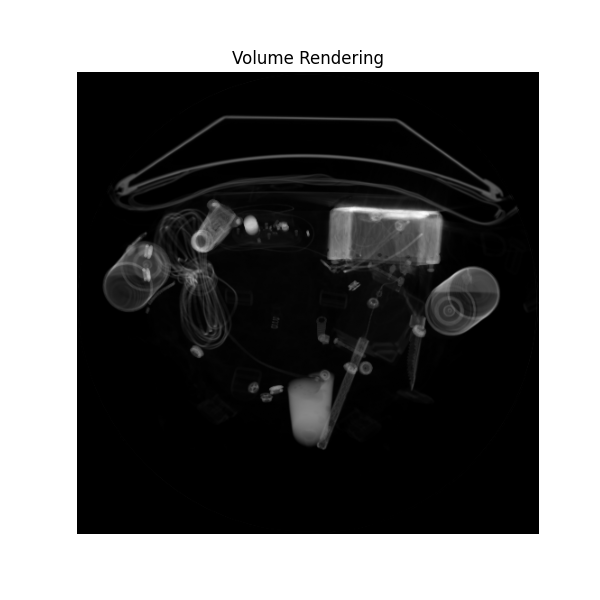

In [3]:
# volume = dataset.read(max_resolution=27, time=0)

def volume_render(volume, density_factor=0.05):
    """
    A simple front-to-back volume rendering (raycasting) algorithm.
    
    This function ray-casts along the z-axis, compositing each slice using a simple transfer function.
    
    Parameters:
        volume (np.ndarray): 3D numpy array with shape (n_slices, height, width).
        density_factor (float): Controls how quickly opacity accumulates.
        
    Returns:
        img (np.ndarray): 2D rendered image from the volume.
    """
    n_slices, height, width = volume.shape
    
    # Initialize the image and an opacity accumulator.
    img = np.zeros((height, width))
    alpha_accum = np.zeros((height, width))
    
    # Compute global minimum and maximum for normalization.
    vmin, vmax = volume.min(), volume.max()
    
    # Ray casting along the z-axis.
    for z in range(n_slices):
        # Normalize the current slice to [0, 1].
        slice_data = (volume[z] - vmin) / (vmax - vmin)
        
        # Compute local opacity using an exponential transfer function.
        alpha = 1 - np.exp(-slice_data * density_factor)
        
        # Composite using front-to-back approach.
        img += (1 - alpha_accum) * slice_data * alpha
        alpha_accum += (1 - alpha_accum) * alpha
        
        # Early termination if nearly opaque.
        if np.all(alpha_accum > 0.99):
            break

    return img

rendered_img = volume_render(volume)
plt.figure(figsize=(6, 6))
plt.imshow(rendered_img, cmap='gray', origin='lower')
plt.title(f'Volume Rendering')
plt.axis('off')
plt.show()

## Camera Rotation

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Yaw\xa0(y) °', max=360.0, s…

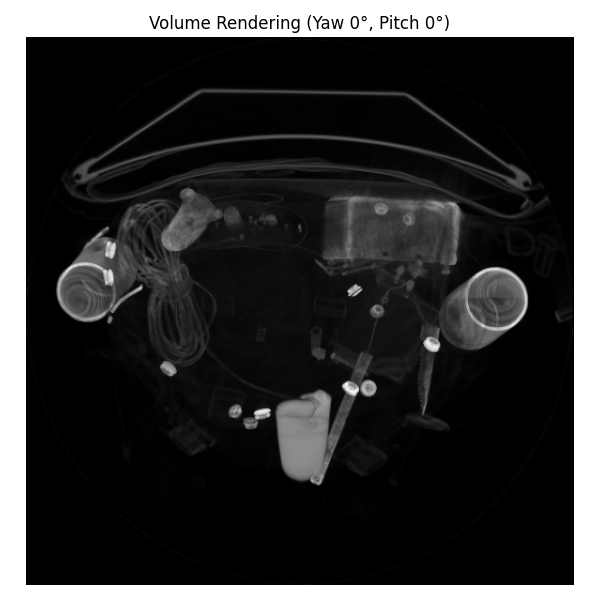

In [4]:
# volume = dataset.read(max_resolution=10, time=0)

# Store the global minimum and maximum of the original volume for consistent normalization
original_vmin, original_vmax = volume.min(), volume.max()

def volume_render_rotated(vol, angle_y=0, angle_x=0, density_factor=0.25):
    """
    First rotate around y‑axis (x–z plane), then around x‑axis (y–z plane),
    finally do front‑to‑back ray‑casting along the new z direction.
    """
    rot_y = ndimage_rotate(vol.astype(np.float32),
                           angle=angle_y,  axes=(2, 0), reshape=False,
                           order=1, mode='constant', cval=float(vol.min()))
    rot_xy = ndimage_rotate(rot_y,
                            angle=angle_x, axes=(1, 2), reshape=False,
                            order=1, mode='constant', cval=float(vol.min()))
    return volume_render(rot_xy, density_factor)

# ------------------------------------------------------------------
#  figure creation
# ------------------------------------------------------------------
initial_img = volume_render_rotated(volume, 0,0)

fig, ax = plt.subplots(figsize=(6, 6))
img_plot = ax.imshow(initial_img, cmap='gray', origin='lower')
ax.set_title('Volume Rendering (Angle: 0°)')
ax.axis('off')
plt.tight_layout()

# ------------------------------------------------------------------
#  callback used by the sliders
# ------------------------------------------------------------------
def update_plot(angle_y, angle_x):
    img = volume_render_rotated(volume, angle_y, angle_x)
    img_plot.set_data(img)
    ax.set_title(f'Volume Rendering (Yaw {angle_y:.0f}°, Pitch {angle_x:.0f}°)')
    fig.canvas.draw_idle()

# ------------------------------------------------------------------
#  hook up the slider
# ------------------------------------------------------------------
yaw_slider   = widgets.FloatSlider(value=0, min=0, max=360, step=5,
                                   description='Yaw (y) °', continuous_update=False)
pitch_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=5,
                                   description='Pitch (x) °', continuous_update=False)

interact(update_plot, angle_y=yaw_slider, angle_x=pitch_slider);

## Add Transfer Function

Read flat volume data with shape: (97779712,)
Reshaped volume to 3D with shape: (373, 512, 512)
Volume min: 0, Volume max: 4071


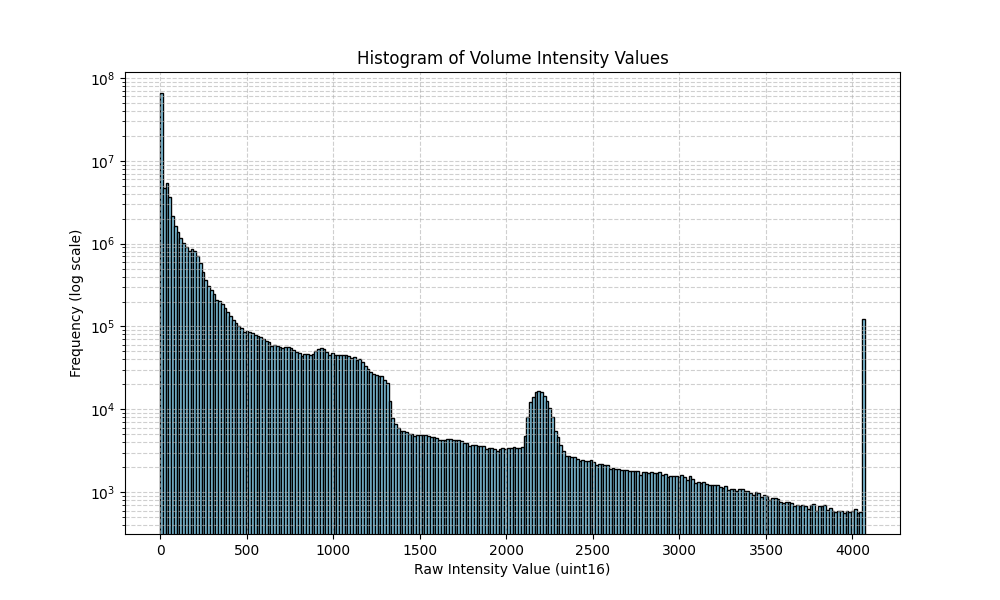

Please examine the histogram to identify intensity ranges corresponding to objects.
Volume raw value range: [0, 4071]
Rendering volume with color transfer function...
Rendering complete.


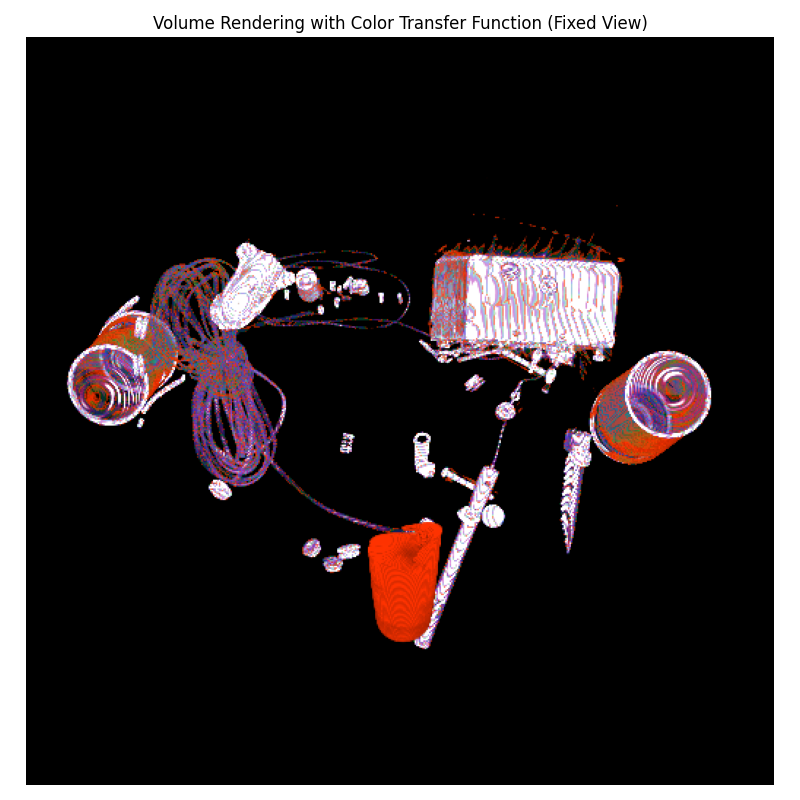

In [5]:
# volume = dataset.read(max_resolution=27, time=0)

# --- Transfer Function (We might need to adjust this based on the data) ---
def simple_transfer_function(normalized_values):
    """
    A simple linear piecewise transfer function mapping normalized
    voxel values to RGBA colors and opacity. Handles array input.

    This function defines a few control points (value, R, G, B, A) and
    linearly interpolates between them.

    Parameters:
        normalized_values (np.ndarray): Voxel values normalized to the range [0, 1].

    Returns:
        np.ndarray: An array of shape (..., 4) containing the RGBA colors and
                    opacities [0, 1] corresponding to the input values.
    """
    v = np.clip(normalized_values, 0, 1) # Ensure value is within [0, 1]
    original_shape = v.shape
    v_flat = v.flatten() # Flatten for easier processing

    # Define control points: (value, R, G, B, A)
    # **You will likely need to adjust these points based on the histogram of your data**
    # These points map normalized intensity values (0 to 1) to RGBA color and opacity.
    # The intensity ranges with non-zero 'A' (alpha) values will be visible.
    points = np.array([
        # Normalized Value, Red, Green, Blue, Alpha (Opacity)
        [0.0,  0.0, 0.0, 0.0, 0.0], # Value 0.0 (raw 0) -> Fully Transparent Black (Background)
        [0.1,  0.0, 0.0, 0.0, 0.0], # Low values (e.g., raw < ~400) -> Still Transparent

        # Focus on the peak around raw values 2200-2400 (normalized ~0.54 - 0.59)
        [0.50, 0.0, 0.0, 0.0, 0.0], # Before the peak -> Transparent
        [0.54, 1.0, 0.2, 0.0, 0.6], # Start of peak -> Bright Orange/Red, significant opacity
        [0.59, 1.0, 0.2, 0.0, 0.6], # End of peak -> Same color/opacity
        [0.60, 0.0, 0.8, 0.1, 0.3], # Just after peak -> Greenish, less opaque

        # Higher value ranges
        [0.70, 0.1, 0.3, 0.9, 0.4], # Higher values -> Bluish, moderate opacity
        [0.85, 0.7, 0.1, 0.7, 0.5], # Even higher -> Purplish, more opaque
        [1.0,  1.0, 1.0, 1.0, 1.0]  # Maximum value (raw 4071) -> Fully Opaque White
    ])

    # Find the two points each flattened value is between
    indices = np.searchsorted(points[:, 0], v_flat)
    # Handle values below the first point and above the last point
    indices = np.clip(indices, 1, len(points) - 1)

    # Get the surrounding points for each value
    p0 = points[indices - 1]
    p1 = points[indices]

    # Calculate the interpolation factor (t) for each value
    denominator = (p1[:, 0] - p0[:, 0])
    t = np.zeros_like(v_flat, dtype=float)
    mask = denominator != 0
    t[mask] = (v_flat[mask] - p0[mask, 0]) / denominator[mask]
    t[~mask] = (v_flat[~mask] >= p1[~mask, 0]).astype(float)

    # Perform linear interpolation for each channel (R, G, B, A)
    rgba_flat = p0[:, 1:] + t[:, np.newaxis] * (p1[:, 1:] - p0[:, 1:])

    # Reshape the result back to the original shape plus the RGBA dimension
    rgba = rgba_flat.reshape(original_shape + (4,))

    return rgba

# --- Volume Rendering Function (remains largely the same) ---
def volume_render_with_tf(volume_data, vmin, vmax, density_factor=1.0):
    n_slices, H, W = volume_data.shape
    img_rgb   = np.zeros((H, W, 3), dtype=np.float32)
    alpha_acc = np.zeros((H, W),     dtype=np.float32)

    for z in range(n_slices):
        norm = np.clip((volume_data[z].astype(np.float32) - vmin) / (vmax - vmin), 0, 1)
        rgba = simple_transfer_function(norm)
        Csrc = rgba[..., :3]                       # (H,W,3)
        Asrc = rgba[...,  3] * density_factor      # (H,W)

        # optional exponential attenuation (comment out if not needed)
        # Asrc = 1.0 - np.exp(-Asrc)

        one_minus_Adest = 1.0 - alpha_acc          # (H,W)
        contrib         = (Csrc * Asrc[..., None]) * one_minus_Adest[..., None]

        img_rgb   += contrib
        alpha_acc += Asrc * one_minus_Adest

        # early‑exit once everything is essentially opaque
        if np.all(alpha_acc > 0.995):
            break

    img_rgb = np.clip(img_rgb, 0, 1)
    return img_rgb

# --- Load the volume data, analyze, render, and display ---

INPUT_PATH = pathlib.Path("backpack_512x512x373_uint16.raw")
VOLUME_DIMS = (373, 512, 512) # Expected shape is (slices, height, width) -> (Z, Y, X)

volume_3d = None # Initialize volume_3d to None
global_vmin = 0
global_vmax = 1 # Initialize min/max

try:
    # Read the raw binary data into a 1D numpy array
    volume_flat = np.fromfile(INPUT_PATH, dtype=np.uint16)
    print(f"Read flat volume data with shape: {volume_flat.shape}")

    # Calculate the expected total number of elements
    expected_elements = VOLUME_DIMS[0] * VOLUME_DIMS[1] * VOLUME_DIMS[2]

    # Check if the number of elements read matches the expected number
    if volume_flat.size != expected_elements:
        print(f"Error: Number of elements read ({volume_flat.size}) does not match expected elements ({expected_elements}) based on dimensions {VOLUME_DIMS}.")
        print("Please check the file path and dimensions.")
        volume_3d = None # Ensure volume_3d remains None
    else:
        # Reshape the 1D array into the 3D shape (slices, height, width)
        volume_3d = volume_flat.reshape(VOLUME_DIMS)
        print(f"Reshaped volume to 3D with shape: {volume_3d.shape}")

        # Calculate global min and max from the 3D NumPy array
        global_vmin = volume_3d.min()
        global_vmax = volume_3d.max()
        print(f"Volume min: {global_vmin}, Volume max: {global_vmax}")

        # --- Analyze and plot Histogram ---
        plt.figure(figsize=(10, 6))
        # Use the flat array for the histogram as it's often faster and shows overall distribution
        plt.hist(volume_flat, bins=256, log=True, color='skyblue', edgecolor='black')
        plt.title('Histogram of Volume Intensity Values')
        plt.xlabel('Raw Intensity Value (uint16)')
        plt.ylabel('Frequency (log scale)')
        plt.grid(True, which='both', linestyle='--', alpha=0.6)
        plt.show()
        print("Please examine the histogram to identify intensity ranges corresponding to objects.")
        print(f"Volume raw value range: [{global_vmin}, {global_vmax}]")


except FileNotFoundError:
    print(f"Error: The file was not found at {INPUT_PATH}")
    volume_3d = None
except Exception as e:
    print(f"An error occurred during file reading or reshaping: {e}")
    volume_3d = None


# --- Perform the single rendering and display (only if volume was loaded successfully) ---

if volume_3d is not None:
    print("Rendering volume with color transfer function...")
    # Call the rendering function with the 3D numpy array and its min/max
    # You can adjust the density_factor here as well (e.g., density_factor=5.0)
    rendered_img_color = volume_render_with_tf(volume_3d, global_vmin, global_vmax, density_factor=1.0)
    print("Rendering complete.")

    # Display the rendered image
    plt.figure(figsize=(8, 8))
    plt.imshow(rendered_img_color, origin='lower')
    plt.title('Volume Rendering with Color Transfer Function (Fixed View)')
    plt.axis('off')
    plt.tight_layout()

    # Show the plot
    plt.show()
else:
    print("Volume data could not be loaded or processed. Rendering skipped.")